# 2023-02-06 More Newton

## Last time

* Newton's method via Taylor series
* Convergence theory for fixed point methods
* Derive Newton's method via fixed point convergence theory

## Today

* Newton methods in computing culture
* Breaking Newton's method
* Exploration
* Portfolios

In [2]:
using Plots
default(linewidth=3, legendfontsize=12)

function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("[$k] x=$x  f(x)=$fx  f'(x)=$fpx")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end

f(x) = cos(x) - x
fp(x) = -sin(x) - 1

fp (generic function with 1 method)

# Convergence of fixed-point (by Taylor Series)

Consider the iteration
$$x_{k+1} = g(x_k)$$
where $g$ is a continuously differentiable function.
Suppose that there exists a fixed point $x_* = g(x_*)$. There exists a Taylor series at $x_*$,
$$ g(x_k) = g(x_*) + g'(x_*)(x_k - x_*) + O((x_k-x_*)^2) $$
and thus
\begin{align}
x_{k+1} - x_* &= g(x_k) - g(x_*) \\
&= g'(x_*) (x_k - x_*) + O((x_k - x_*)^2).
\end{align}

In terms of the error $e_k = x_k - x_*$,
$$ \left\lvert \frac{e_{k+1}}{e_k} \right\rvert = \lvert g'(x_*) \rvert + O(e_k).$$



Recall the definition of q-linear convergence
$$ \lim_{k\to\infty} \left\lvert \frac{e_{k+1}}{e_k} \right\rvert = \rho < 1. $$

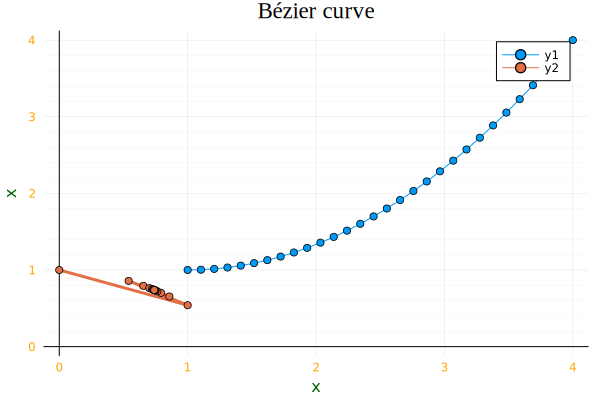

In [3]:
xstar, _ = newton(f, fp, 1.)
g(x) = cos(x)
gp(x) = -sin(x)


function fixed_point(g, x, n)
    xs = [x]
    for k in 1:n
        x = g(x)
        append!(xs, x)
    end
    xs
end

xs = fixed_point(g, 0., 15)
plot!(xs, g.(xs), seriestype=:path, marker=:auto)

# Verifying fixed point convergence theory


$$ \left\lvert \frac{e_{k+1}}{e_k} \right\rvert \to \lvert g'(x_*) \rvert $$

In [4]:
@show gp(xstar)
es = xs .- xstar
es[2:end] ./ es[1:end-1]

gp(xstar) = -0.6736120293089505


15-element Vector{Float64}:
 -0.3530241034880909
 -0.7618685362635164
 -0.5959673878312852
 -0.7157653025686597
 -0.6414883589709152
 -0.6933762938713267
 -0.6595161800339986
 -0.6827343083372247
 -0.667303950535869
 -0.677785479788835
 -0.670766892391035
 -0.6755130653097281
 -0.6723244355324894
 -0.6744762481989985
 -0.6730283414604459

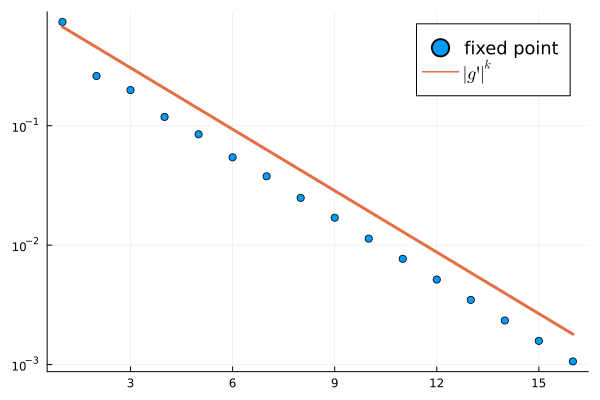

In [5]:
scatter(abs.(es), yscale=:log10, label="fixed point")
plot!(k -> abs(gp(xstar))^k, label="\$|g'|^k\$")

# Plotting Newton convergence

In [6]:
function newton_hist(f, fp, x0; tol=1e-12)
    x = x0
    hist = []
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        push!(hist, [x fx fpx])
        if abs(fx) < tol
            return vcat(hist...)
        end
        x = x - fx / fpx
    end
end

newton_hist (generic function with 1 method)

x_star = xs[end, 1] = 0.7390851332151607


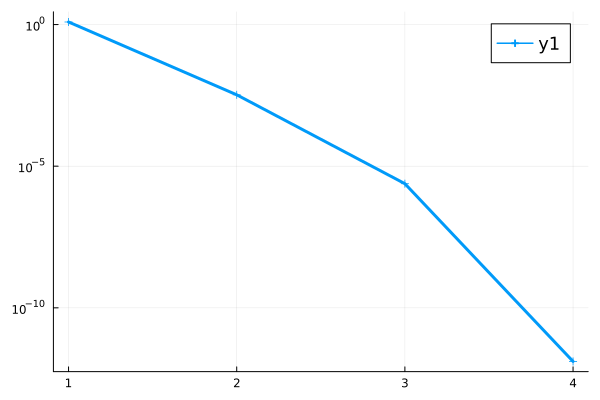

In [7]:
xs = newton_hist(f, fp, 1.97)
@show x_star = xs[end,1]
plot(xs[1:end-1,1] .- x_star, yscale=:log10, marker=:auto)

## Poll: Is this convergence A=q-linear, B=r-linear, C=neither?

# Formulations are not unique (functions)

If $x = g(x)$ then
$$x = \underbrace{x + h(x) \big(g(x) - x\big)}_{g_3(x)}$$
for any smooth $h(x) \ne 0$. Can we choose $h(x)$ to make $\lvert g_3'(x) \rvert$ small?

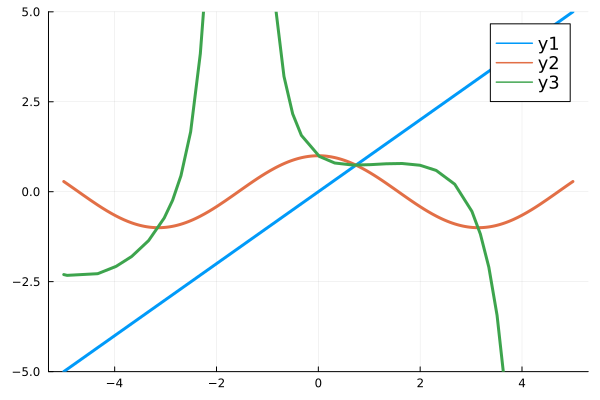

In [9]:
h(x) = -1 / (gp(x) - 1)
g3(x) = x + h(x) * (g(x) - x)
plot([x-> x, cos, g3], ylims=(-5, 5))

* We don't know $g'(x_*)$ in advance because we don't know $x_*$ yet.
* This method converges very fast
* We actually just derived Newton's method.

# A fresh derivation of Newton's method

* A rootfinding problem $f(x) = 0$ can be converted to a fixed point problem $$x = x + f(x) =: g(x)$$ but there is no guarantee that $g'(x_*) = 1 + f'(x_*)$ will have magnitude less than 1.
* Problem-specific algebraic manipulation can be used to make $|g'(x_*)|$ small.
* $x = x + h(x) f(x)$ is also a valid formulation for any $h(x)$ bounded away from $0$.
* Can we choose $h(x)$ such that $$ g'(x) = 1 + h'(x) f(x) + h(x) f'(x) = 0$$ when $f(x) = 0$?

In other words,
$$ x_{k+1} = x_k + \underbrace{\frac{-1}{f'(x_k)}}_{h(x_k)} f(x_k)  . $$

# Quadratic convergence!

$$ \left\lvert \frac{e_{k+1}}{e_k} \right\rvert \to \lvert g'(x_*) \rvert $$

* What does it mean that $g'(x_*) = 0$?
* It turns out that Newton's method has _locally quadratic_ convergence to simple roots,
$$\lim_{k \to \infty} \frac{|e_{k+1}|}{|e_k|^2} < \infty.$$
* "The number of correct digits doubles each iteration."
* Now that we know how to make a good guess accurate, the effort lies in getting a good guess.

# Culture: fast inverse square root

The following code appeared literally (including comments) in the Quake III Arena source code (late 1990s).

```c
float Q_rsqrt( float number )
{
	long i;
	float x2, y;
	const float threehalfs = 1.5F;

	x2 = number * 0.5F;
	y  = number;
	i  = * ( long * ) &y;                       // evil floating point bit level hacking
	i  = 0x5f3759df - ( i >> 1 );               // what the fuck? 
	y  = * ( float * ) &i;
    y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
//  y  = y * ( threehalfs - ( x2 * y * y ) );   // 2nd iteration, this can be removed

	return y;
}
```

We now have [vector instructions](https://software.intel.com/sites/landingpage/IntrinsicsGuide/#text=rsqrt&expand=2989,1224,4470) for approximate inverse square root.
More at https://en.wikipedia.org/wiki/Fast_inverse_square_root

# How does it work?

Let's look at the last line
```c
y  = y * ( threehalfs - ( x2 * y * y ) );   // 1st iteration
```

We want a function $f(y)$ such that $f(1/\sqrt{x}) = 0$. One such function is
$$ f(y) = 1/y^2 - x, \quad f'(y) = -2/y^3.$$

There are others, e.g.,
$$f_1(y) = y^2 - 1/x,\quad f'(y) = 2 y,$$
but this would require a division.

Newton's method is
\begin{align}
y_{k+1} &= y_k - \frac{f(y_k)}{f'(y_k)} \\
&= y_k - \frac{1/y_k^2 - x}{-2/y_k^3} \\
&= y_k + \frac 1 2 (y_k - x y_k^3) \\
&= y_k \left(\frac 3 2 - \frac 1 2 x y_k^2\right)
\end{align}

# Rootfinding outlook

* Newton methods are immensely successful
  * Convergence theory is local; we need good initial guesses (activity)
  * Computing the derivative $f'(x)$ is *intrusive*
    * Avoided by secant methods (approximate the derivative; activity)
    * Algorithmic or numerical differentiation (future topics)
  * Bisection is robust when conditions are met
  * Line search (activity)
  * When does Newton diverge?

* More topics
  * Find *all* the roots
  * Use Newton-type methods with bounds
  * Times when Newton converges slowly

In [17]:
log(Complex(-1. - 1e-15im))

5.0e-31 - 3.1415926535897922im

# Exploratory rootfinding

* Find a function $f(x)$ that models something you're interested in. You could consider nonlinear physical models (aerodynamic drag, nonlinear elasticity), behavioral models, probability distributions, or anything else that that catches your interest. Implement the function in Julia or another language.

* Consider how you might know the output of such functions, but not an input. Think from the position of different stakeholders: is the equation used differently by an experimentalist collecting data versus by someone making predictions through simulation? How about a company or government reasoning about people versus the people their decisions may impact?

* Formulate the map from known to desired data as a rootfinding problem and try one or more methods (Newton, bisection, etc., or use a rootfinding library).

* Plot the inverse function (output versus input) from the standpoint of one or more stakeholder. Are there interesting inflection points? Are the methods reliable?

* If there are a hierarchy of models for the application you're interested in, consider using a simpler model to provide an initial guess to a more complicated model.

# Equation of state example

Consider an [equation of state](https://en.wikipedia.org/wiki/Real_gas#Beattie%E2%80%93Bridgeman_model) for a real gas, which might provide pressure $p(T, \rho)$ as a function of temperature $T$ and density $\rho = 1/v$.

* An experimentalist can measure temperature and pressure, and will need to solve for density (which is difficult to measure directly).
* A simulation might know (at each cell or mesh point, at each time step) the density and internal energy, and need to compute pressure (and maybe temperature).
* An analyst might have access to simulation output and wish to compute entropy (a thermodynamic property whose change reflects irreversible processes, and can be used to assess accuracy/stability of a simulation or efficiency of a machine).

The above highlights how many equations are incomplete, failing to model how related quantities (internal energy and entropy in this case) depend on the other quantities. Standardization bodies (such as NIST, here in Boulder) and practitioners often prefer models that intrinsically provide a complete set of consistent relations. An elegent methodology for equations of state for gasses and fluids is by way of the [Helmholtz free energy](http://www.coolprop.org/fluid_properties/PurePseudoPure.html#pure-and-pseudo-pure-fluid-properties), which is not observable, but whose partial derivatives define a complete set of thermodynamic properties. The [CoolProp](http://www.coolprop.org) software has highly accurate models for many gasses, and practitioners often build less expensive models for narrower ranges of theromdynamic conditions.